<a href="https://colab.research.google.com/github/Seham-Nasr/Practical_XAI/blob/main/Concept_basedXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Seham-Nasr/Practical_XAI.git

Cloning into 'Practical_XAI'...
remote: Enumerating objects: 556, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 556 (delta 4), reused 0 (delta 0), pack-reused 547 (from 1)
Receiving objects: 100% (556/556), 50.12 MiB | 41.49 MiB/s, done.
Resolving deltas: 100% (96/96), done.


# Concept Relevance Propagation

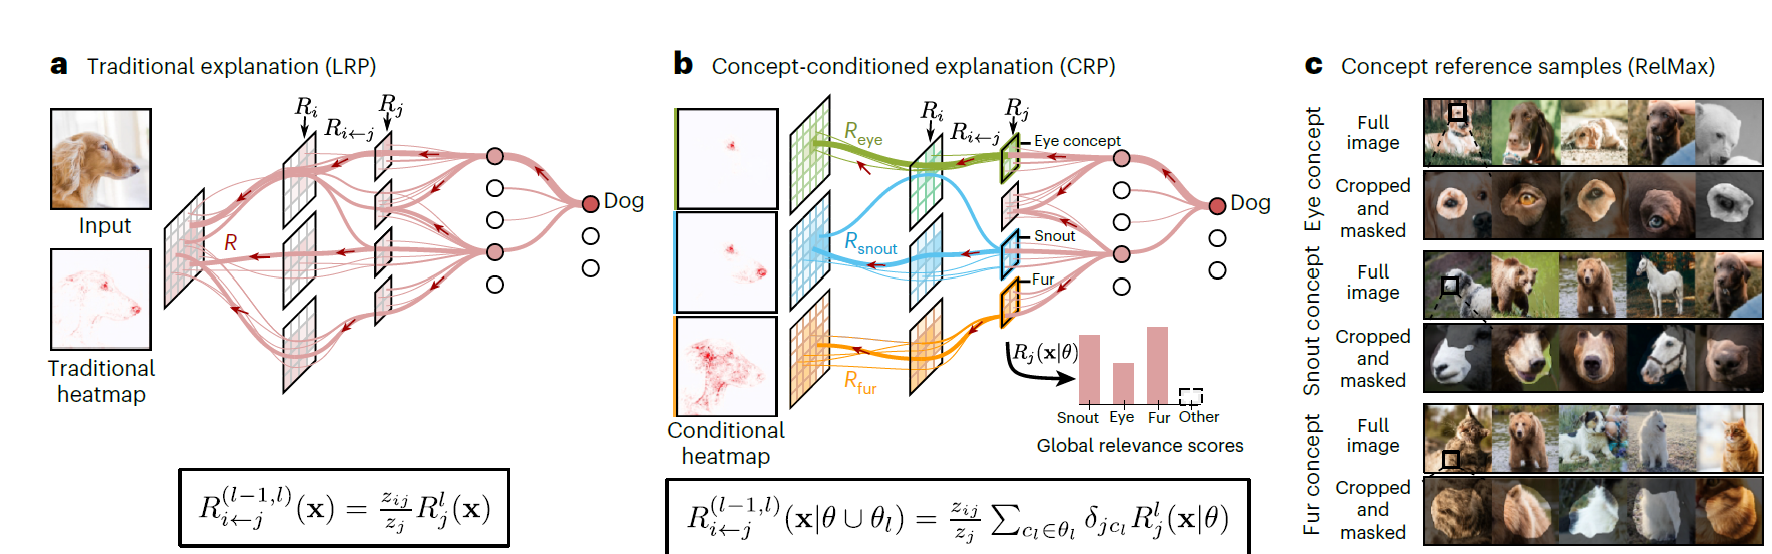

In this notebook, we will explore how to visualize which concepts individual CNN channels and MLP neurons encode.

In [3]:
# Install necessary packages
# Uncomment the following line to install the required package
!pip install zennit-crp[fast_img]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.6/904.6 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.3 MB/s eta 0:00:00
 

# 1. Computing Feature Visualizations

Let's start again by initializing the VGG16 model

In [3]:
%cd Practical_XAI/

/content/Practical_XAI


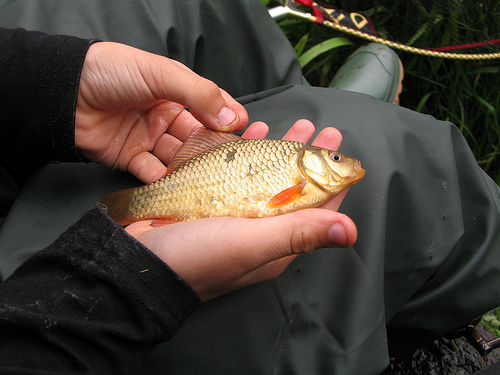

In [4]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
import requests
from io import BytesIO

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

# Load image
path = 'subset_imagenet/val/n01440764/ILSVRC2012_val_00026064.JPEG'
orig_img = Image.open(path).convert('RGB')
transform = T.Compose([
    T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
sample = transform(orig_img).unsqueeze(0).to(device)
sample.requires_grad = True

orig_img

The `FeatureVisualization` class contains the functionality to visualize concepts. For this, we must first define what kind of concept is used in which layer of the model by initializing a `layer_map` dictionary. Moreover, we need a dataset through which we iterate and a `CondAttribution` object that describes how attributions should be computed on the dataset.

In [5]:
import torchvision
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
#from utils import download

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)

# separate normalization from resizing for plotting purposes later
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_path = "/content/Practical_XAI/subset_imagenet" #TODO fill or run download below

'''if data_path is None:
    # download ImageNet validation set
    data_path = "ImageNet_data"
    download(data_path)'''

# apply no normalization here!
imagenet_data = torchvision.datasets.ImageNet(data_path, transform=transform, split="val")

# get subset of data
#imagenet_data = torch.utils.data.Subset(imagenet_data, range(100))

Finally, we initialize the `FeatureVisualization` class with a custom preprocessing function.

In [6]:
fv_path = "VGG16_ImageNet"
fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path=fv_path)

In [7]:
''' Now run the analysis or skip it by going to the next line of Python code
   (the analysis results for layer features.40 were precomputed and are located inside the VGG16_ImageNet directory).'''
# it will take approximately sometime to run this, depending on your hardware
# you can reduce the number of images to speed up the process
saved_files = fv.run(composite, 0, len(imagenet_data), 32, 100)

Running Analysis...


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


100%|██████████| 64/64 [00:00<00:00, 499.41it/s]


### Select the top Concepts

In [8]:
from crp.helper import get_layer_names

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

conditions = [{'y': [0]}]  # condition for class 0, e.g., 'n01440764' for 'n01440764/ILSVRC2012_val_00026064.JPEG'
attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['features.40'].shape, attr.relevances['features.40'].shape

(torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]))

The attribute method of the ChannelConcept class assigns relevance to each concept. The first element corresponds to the first channel and so on.

In [9]:
attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['features.40'].shape, attr.relevances['features.40'].shape
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['features.40'], abs_norm=True)
rel_c.shape

torch.Size([1, 512])

In [10]:
# the five most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 5)
concept_ids, rel_values*100

(tensor([384, 152, 428, 358,  71], device='cuda:0'),
 tensor([8.6361, 6.7343, 2.7942, 2.6013, 1.9227], device='cuda:0'))

we discovered the 5 most important concepts in classifying the fish known as tench (Tinca tinca). Now let's visualize the 8 most representative input samples for each of these concepts using Relevance Maximization.

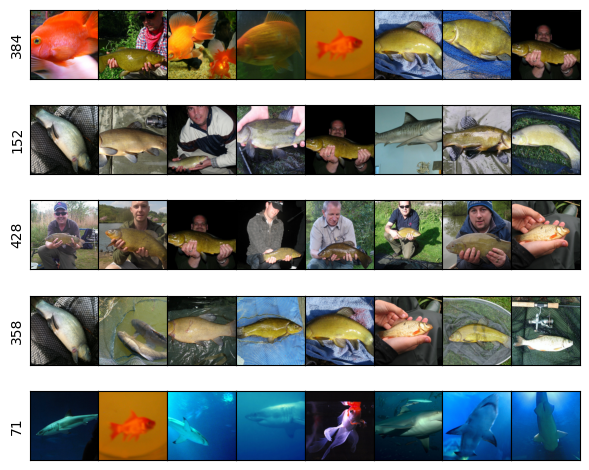

In [11]:
%matplotlib inline
from crp.image import plot_grid

ref_c = fv.get_max_reference([384, 152, 428, 358,  71], "features.40", "relevance", (0, 8)) # 469, 35, 89, 316, 161

plot_grid(ref_c, figsize=(6, 5), padding=False)

# 2. Conditonal Heatmaps on Reference Samples

The room for interpretation in the pictures is large. One does not know exactly which part to focus on. Therefore, we can compute conditional heatmaps for the concepts. The intern attribution method of the CondAttribution class starts the backward pass directly at the layer of the concept and initializes with the activation of the channel, so that we achieve a localization of the concept in input space. The method get_max_reference returns then the reference samples as well as attribution heatmaps as separate lists in the dictionary.

To achieve this, we simply supply a zennit composite to the composite argument describing the rule used for computing attributions.

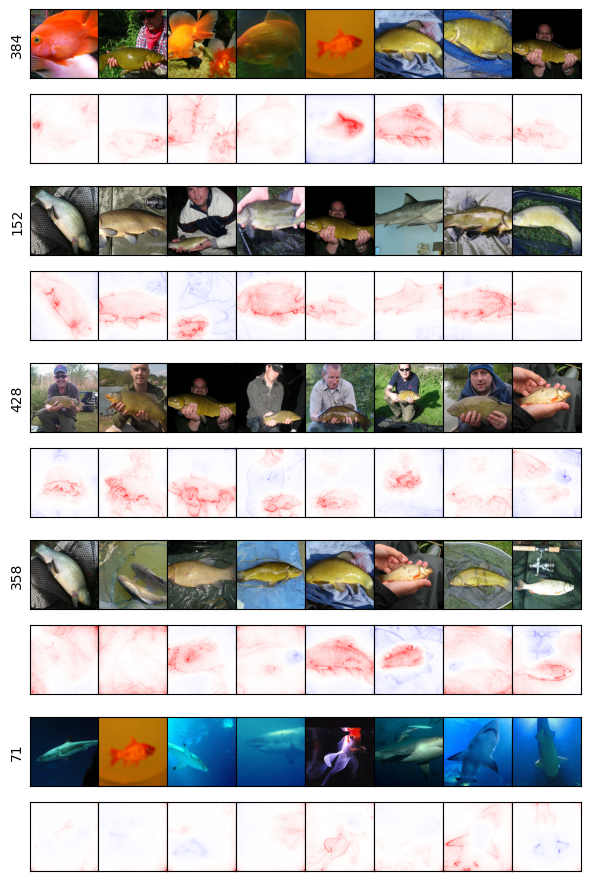

In [12]:
ref_c = fv.get_max_reference([384, 152, 428, 358,  71], "features.40", "relevance", (0, 8), composite=composite, plot_fn=None)

plot_grid(ref_c, figsize=(6, 9))

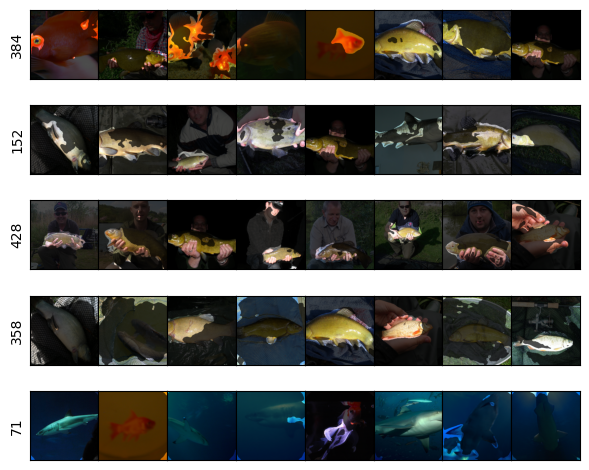

In [13]:
from crp.image import vis_opaque_img

ref_c = fv.get_max_reference([384, 152, 428, 358,  71], "features.40", "relevance", (0, 8), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(6, 5))